<a href="https://colab.research.google.com/github/grcmupc/portrait/blob/main/tutorials/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluation 

This colab allows appyling previously trained policies stored with policy_saver to desired evaluation data. 

## Import libraries

In [ ]:
pip install tf-agents

In [ ]:
import tensorflow as tf
import csv
import pandas as pd
import numpy as np
import os
import tempfile
import zipfile
import shutil
import statistics as st
from pandas import DataFrame
from itertools import product
import matplotlib.pyplot as plt

from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import tf_py_environment
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.trajectories import policy_step
from tf_agents.specs import array_spec
from tf_agents.environments import py_environment
from tf_agents.trajectories import time_step as ts

tf.compat.v1.enable_v2_behavior()
tf.version.VERSION

'2.8.0'

## Configure 5G environment

In [ ]:
k_tenants=2 #Number of Tenants
n_BS=5 #Number of BSs
Nt=65 #Total number of PRBs in each cell
Seff=5 #Average Spectral efficiency in each cell
PRB_B=360e3 #PRB Bandwidth
Ct=Nt*Seff*PRB_B #Total capacity in the cell
Ct_allcells=Ct*n_BS #Total capacity in the system

pos_actions=[-3,0,3] #Possible actions per 
n_rep=5 #Number of repetitions for each row in the offered load files (simulation of time step duration)

## Include all the required functions for the evaluation

In [ ]:
def obtain_data_from_dataset(df_data,n_rep, Ct_allcells, Ct):

  #Obtain data from each column (configure columns)
  dataT1=df_data.values.T[0].tolist()#Offered load Tenant 1
  dataT2=df_data.values.T[1].tolist()#Offered load Tenant 2
  SAGBR_perc_T1=df_data.values.T[2].tolist()#SAGBR Tenant 1
  SAGBR_perc_T2=df_data.values.T[3].tolist()#SAGBR Tenant 2
  MCBR_perc_T1=df_data.values.T[4].tolist()#SAGBR Tenant 1
  MCBR_perc_T2=df_data.values.T[5].tolist()#SAGBR Tenant 2

  O_k_T1=[]
  O_k_T2=[]
  SAGBR_k_T1=[]
  SAGBR_k_T2=[]
  MCBR_k_T1=[]
  MCBR_k_T2=[]

  #Process data
  for i in range(len(dataT1)): 
    for _ in range(n_rep):
      O_k_T1.append(dataT1[i]*Ct)
      O_k_T2.append(dataT2[i]*Ct)
      SAGBR_k_T1.append(SAGBR_perc_T1[i]*Ct_allcells)
      SAGBR_k_T2.append(SAGBR_perc_T2[i]*Ct_allcells)
      MCBR_k_T1.append(MCBR_perc_T1[i]*Ct)
      MCBR_k_T2.append(MCBR_perc_T2[i]*Ct)
  O_k_n=[O_k_T1,O_k_T2]
  SAGBR=[SAGBR_k_T1,SAGBR_k_T2]
  MCBR=[MCBR_k_T1,MCBR_k_T2]

  return O_k_n, SAGBR, MCBR

In [ ]:
class BS():

    def __init__(self,k_tenants,BS_id,Nt,Seff,PRB_B,initial_share,SAGBR,MABR,O_k_n):
        self.k_tenants=k_tenants
        self.BS_id=BS_id
        self.Nt=Nt
        self.Seff=Seff
        self.PRB_B=PRB_B
        self.Ct=self.Nt*self.Seff*self.PRB_B
        self.share=initial_share
        self.MABR=MABR 
        self.SAGBR=SAGBR       
        self.O_k=O_k_n      
        self.Thr_k=[[],[]]
        self.pG_k=[[],[]]
        self.time_step=0 #number of time steps performed
        self.time_step_chunk=0
        self.total_steps=len(self.O_k[0])
        self.SThr=[[],[]]

        #Params to evaluate       
        self.action_history=[[0],[0]] #It is considered that the first action is 0
        self.share_history=[[0.6],[0.4]]
        
    def reset(self,share):
        self.time_step=0
        self.time_step_chunk=0
        self.share=share
        self.Thr_k=[[],[]]
        self.pG_k=[[],[]]
        self.action_history=[[0],[0]]
        self.share_history=[[0.6],[0.4]]

    #Get the current state
    def get_state(self,tenant):   
          
        total_pG=0
        for i in range(self.k_tenants):
            total_pG+=self.pG_k[i][-1]

        return [self.pG_k[tenant][-1],self.share[tenant],max(1-sum(self.share),0),max(1-total_pG,0)]

    #Provide return parameters [Cthr, pg_k,Ok_real, Ok_modif, C_ass_n]
    def get_performance(self,tenant):
        return [self.Thr_k[tenant][-1],self.pG_k[tenant][-1],self.O_k[tenant][self.time_step_chunk-1],min(self.O_k[tenant][self.time_step_chunk-1],self.MABR[tenant][self.time_step_chunk-1]),self.Ct*self.share[tenant]]

    #Configure a new action
    def set_action(self,action,tenant):
        self.action_history[tenant].append(action)

    def inform_system_thr(self,SThr,tenant):
        self.SThr[tenant]=SThr      

    def apply_actions(self):
        #Compute expected share with last actions
        expected_share=np.zeros(self.k_tenants)
        last_action=np.zeros(self.k_tenants) #used to identify
        for k in range(self.k_tenants):
            expected_share[k]=self.share[k]+self.action_history[k][-1]/100
            last_action[k]=self.action_history[k][-1]
            if expected_share[k]>self.MABR[k][self.time_step_chunk]/self.Ct:
                expected_share[k]=self.MABR[k][self.time_step_chunk]/self.Ct
                last_action[k]=0
            elif expected_share[k]<0:
                expected_share[k]=0
                last_action[k]=0

        #Check if conflict
        if sum(expected_share)<=1: #No conflict
            self.share=expected_share
        else: #conflict: summation of share is larger than 1
            #If there are no enough resources, those tenants above SAGBR cannot increase their PRBs
            tenants_no_increase = [item.tolist() for item in np.where(np.array(last_action)<=0)][0] #Index of tenants that do not increase
            tenants_increase=[item.tolist() for item in np.where(np.array(last_action)>0)][0] #Index tenants that want to increase

            for k in tenants_no_increase: #Apply actions of tenants that do not ask to increase
                self.share[k]=expected_share[k]

            traffic_below=0
            for k in tenants_increase: #detect if there are tenants with traffic below SAGBR
                if self.SThr[k]<self.SAGBR[k][self.time_step_chunk]:
                    traffic_below=1

            for k in tenants_increase:
                if self.SThr[k]>self.SAGBR[k][self.time_step_chunk] and traffic_below==1: #those that are above SAGBR need to decrease if there is some that is below
                    last_action[k]=-self.action_history[k][-1]
                    expected_share[k]=self.share[k]+last_action[k]/100
                    self.share[k]=expected_share[k]
                    
            tenants_increase=[item.tolist() for item in np.where(np.array(last_action)>0)][0] #Index tenants that want to increase (update)

            if sum(self.share)<1: #If the result decreasing or and 0 actions give 1, do nothing. Else:
                denom=sum([self.SAGBR[k][self.time_step_chunk] for k in tenants_increase])
                Av_share=1-sum(self.share)
                #actions_tenants_increase=[self.action_history[k][-1] for k in tenants_increase]
                action_sharing=np.zeros(self.k_tenants)
                for k in tenants_increase: 
                    action_sharing[k]=(self.SAGBR[k][self.time_step_chunk]/denom) 
                    self.share[k]=self.share[k]+Av_share*action_sharing[k]/100 #Share according to last SLA
            
        for k in range(self.k_tenants):
            self.share_history[k].append(self.share[k])

    #Execute the environment for a step
    def run(self): 

        #Apply actions set by agents in the environment
        self.apply_actions()
        
        #Obtain current slice throughput and occupation
        total_thr=0
        for k in range(self.k_tenants):
            if self.O_k[k][self.time_step_chunk]<self.share[k]*self.Ct:
                self.Thr_k[k].append(self.O_k[k][self.time_step_chunk])
                
            else:
                self.Thr_k[k].append(self.share[k]*self.Ct)
                
            total_thr+=self.Thr_k[k][-1]
               
        #Compute occupation 
        for k in range(self.k_tenants):
            self.pG_k[k].append(self.Thr_k[k][-1]/self.Ct)
                     
        self.time_step+=1
        self.time_step_chunk+=1

    def import_data_chunk_BS(self, O_chunk_k_n, SAGBR_chunk, MCBR_chunk):
        self.O_k_n=O_chunk_k_n
        self.SAGBR=SAGBR_chunk
        self.MABR=MCBR_chunk
        self.time_step_chunk=0

In [ ]:
class BS_controller():
  def __init__(self,k_tenants,n_BS,Nt,Seff,PRB_B,Ct,SAGBR,MABR,O_k_n):
    self.k_tenants=k_tenants
    self.n_BS=n_BS

    #BS_configuration
    self.Nt=Nt
    self.Seff=Seff
    self.PRB_B=PRB_B
    self.Ct=Ct
    self.SAGBR=SAGBR
    self.MABR=MABR
    self.initial_share=[self.SAGBR[k][0]/sum([self.SAGBR[i][0] for i in range(len(self.SAGBR))]) for k in range(self.k_tenants)]
    self.reward_factors=[0,0,0.5,0.4]
    self.BS_set=[] 
    self.total_capacity=self.n_BS*self.Ct

    self.O_k_n=O_k_n

    self.initialise_BS()

    self.total_steps=len(self.O_k_n[0]) #Total time steps to perfrom
    self.time_step=0 #number of time steps performed
    self.time_step_chunk=0 #time step in the current chunk of data

    self.reward_history=[[0],[0]]
    self.fi_SLA_history=[[1],[1]]
    self.fi_ut_history=[[0],[0]]
    self.fi_extra_history=[[0],[0]]
    self.total_O_k_history=[[0],[0]]
    self.beta_k_history=[[0],[0]]
    self.Thr_k=[[],[]]#System level throughput (sumation of all BS)
    self.pG_k=[[],[]]
    self.O_k=[[],[]]
    self.O_k_modif=[[],[]]
    self.C_ass_k=[[],[]]
    
    self.run()


  def initialise_BS(self):
      for n in range(self.n_BS): 
          self.BS_set.append(BS(self.k_tenants,n,self.Nt,self.Seff,self.PRB_B,self.initial_share,self.SAGBR,self.MABR,self.O_k_n))

  def reset(self):
      for n in range(self.n_BS):
          self.BS_set[n].reset(self.initial_share)
      self.time_step=0 #number of time steps performed
      self.time_step_chunk=0 #time step in the current chunk of data
      self.reward_history=[[0],[0]]
      self.fi_SLA_history=[[1],[1]]
      self.fi_ut_history=[[0],[0]]
      self.fi_extra_history=[[0],[0]]
      self.total_O_k_history=[[0],[0]]
      self.beta_k_history=[[0],[0]]
      self.Thr_k=[[],[]]#System level throughput (sumation of all BS)
      self.pG_k=[[],[]]
      self.O_k=[[],[]]
      self.O_k_modif=[[],[]]
      self.C_ass_k=[[],[]]

      self.run()

  def get_state(self,tenant):
      pG_k=[]
      share_k=[]
      av_share_k=[]
      av_pg_k=[]
      MCBR=[]    
      
      for n in range(self.n_BS):
          BS_state=self.BS_set[n].get_state(tenant)
          pG_k.append(BS_state[0]) # ocupation
          share_k.append(BS_state[1]) #tenant's share
          av_share_k.append(BS_state[2]) #Share not used by any tenant
          av_pg_k.append(BS_state[3])
          MCBR.append(self.MABR[tenant][self.time_step_chunk]/self.BS_set[n].Ct)
          

      #Last row --> SAGBR(k), SAGBR_others, 0, 0 ,0
      pG_k.append(self.SAGBR[tenant][self.time_step_chunk]/self.total_capacity)
      SAGBR_others=0
      for i in range(self.k_tenants):
          if i!=tenant:
              SAGBR_others+=self.SAGBR[i][self.time_step_chunk]
      share_k.append(SAGBR_others/self.total_capacity)
      av_share_k.append(0)
      av_pg_k.append(0)
      MCBR.append(0)

      return [pG_k,share_k,av_share_k,av_pg_k,MCBR]

  def get_reward(self,tenant):
      fi_SLA_tenants=np.ones(self.k_tenants)
      fi_ut=0
      fi_extra=1
      sum_Thr=0

      for k in range(self.k_tenants):
          if self.O_k_modif[k][-1]>0:
              sla_ratio=self.Thr_k[k][-1]/min(self.O_k_modif[k][-1],self.SAGBR[k][self.time_step_chunk])   
              fi_SLA_tenants[k]=min(sla_ratio,1)
              sum_Thr+=self.Thr_k[k][-1]

      fi_SLA_othertenants=1/(self.k_tenants-1)*sum(fi_SLA_tenants[k] for k in range(self.k_tenants) if k!=tenant)
      fi_SLA=fi_SLA_tenants[tenant]

      if self.C_ass_k[tenant][-1]>0:
          fi_ut=self.Thr_k[tenant][-1]/(self.C_ass_k[tenant][-1])
      elif self.O_k_modif[tenant][-1]==0:
          fi_ut=1

      total_O_k=0
      beta_k=0 #extra capacity not required by other tenants
      for k in range(self.k_tenants):
          total_O_k+=self.O_k_modif[k][-1]
          if k!=tenant:
              beta_k+=max(self.SAGBR[k][self.time_step_chunk]-self.O_k_modif[k][-1],0)

      if self.O_k_modif[tenant][-1]==0:
          fi_extra=1
      elif total_O_k>self.total_capacity:
          fi_extra=min(self.Thr_k[tenant][-1]/min(self.SAGBR[tenant][self.time_step_chunk]+beta_k,self.O_k_modif[tenant][-1]),1)
      else:
          fi_extra=self.Thr_k[tenant][-1]/self.O_k_modif[tenant][-1]
    
      reward=(fi_SLA**self.reward_factors[0])*(fi_SLA_othertenants**self.reward_factors[1])*(fi_ut**self.reward_factors[2])*(fi_extra**self.reward_factors[3])

      self.reward_history[tenant].append(reward)
      self.fi_SLA_history[tenant].append(fi_SLA)
      self.fi_ut_history[tenant].append(fi_ut)
      self.fi_extra_history[tenant].append(fi_extra)
      self.total_O_k_history[tenant].append(total_O_k)
      self.beta_k_history[tenant].append(beta_k)
      
      return reward

  def set_action(self,actions,tenant):
      for n in range(self.n_BS):
          self.BS_set[n].set_action(actions[n],tenant)
          self.BS_set[n].inform_system_thr(self.Thr_k[tenant][-1],tenant)

  def run(self): 
      Thr=np.zeros(self.k_tenants)
      pG=np.zeros(self.k_tenants)
      Oreal_k=np.zeros(self.k_tenants)
      Omodif_k=np.zeros(self.k_tenants)
      C_ass=np.zeros(self.k_tenants)

      for n in range(self.n_BS):
          self.BS_set[n].run()

          #Gather throughput and occupation
          for k in range(self.k_tenants):
              results=self.BS_set[n].get_performance(k)
              Thr[k]+=results[0]
              pG[k]+=results[1]
              Oreal_k[k]+=results[2]
              Omodif_k[k]+=results[3]
              C_ass[k]+=results[4]
      
      #Store performance data- Required for reward computation
      for k in range(self.k_tenants):
          self.Thr_k[k].append(Thr[k])
          self.pG_k[k].append(pG[k])
          self.O_k[k].append(Oreal_k[k])
          self.O_k_modif[k].append(Omodif_k[k])
          self.C_ass_k[k].append(C_ass[k])    

      self.time_step+=1
      self.time_step_chunk+=1

  def import_data_chunk(self, O_chunk_k_n, SAGBR_chunk, MCBR_chunk):
      self.O_k_n=O_chunk_k_n
      self.SAGBR=SAGBR_chunk
      self.MABR=MCBR_chunk
      self.time_step_chunk=0

      for n in range(self.n_BS):
          self.BS_set[n].import_data_chunk_BS(O_chunk_k_n,SAGBR_chunk,MCBR_chunk)

  def initialise_params_time_step(self): 
      for k in range(self.k_tenants):
          self.Thr_k[k].append(0)
          self.pG_k[k].append(0)
          self.O_k[k].append(0)
          self.O_k_modif[k].append(0)
          self.C_ass_k[k].append(0)

          for n in range(self.n_BS): 
              self.BS_set[n].Thr_k[k].append(0)
              self.BS_set[n].pG_k[k].append(0)      

  def next_time_step(self):
      for k in range(self.k_tenants):
          self.get_reward(k)
      for n in range(self.n_BS): 
          self.BS_set[n].next_time_step_BS()
      self.time_step+=1
      self.time_step_chunk+=1

In [ ]:
class environment_5G_multipleBS(py_environment.PyEnvironment):

    def __init__(self,tenant_id,bs_controller,pos_actions):

        self.tenant_id=tenant_id
        self.bs_controller=bs_controller

        self.possible_actions_cell=pos_actions
        self.n_BS=self.bs_controller.n_BS

        self.possible_actions=[val for val in product(self.possible_actions_cell,repeat=self.n_BS)]
        self.n_actions=len(self.possible_actions)
        
        #Set format of actions. Possible actions of an agent considering
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int64, minimum=0, maximum=self.n_actions-1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(5,self.n_BS+1), dtype=np.float32, minimum=0, name='observation')
            #For each state defined by the <pg, share_k, share_ava, 1-sum(pg), MCBR(n)> for each BS
            #Last row, SAGBR(k) and sum(SAGBR(k') for k'=!k)
        
        self.last_action=0
        self._state=self.bs_controller.get_state(self.tenant_id)
        self._episode_ended=False       

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self.bs_controller.reset()
        self._state = self.bs_controller.get_state(self.tenant_id)
        self.last_action=0
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.float32))

    def _step(self, action):   
        
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()

        # Obtain state after action
        self._state=self.bs_controller.get_state(self.tenant_id)
        # Obtain reward after last action
        self.reward=self.bs_controller.get_reward(self.tenant_id)

        # Construct step to return
        if self._episode_ended:
            next_step=ts.termination(np.array(self._state, dtype=np.float32), self.reward)
        else:
            next_step=ts.transition(np.array(self._state, dtype=np.float32), reward=self.reward, discount=0.9)
        
        if isinstance(action,np.ndarray):
            action=action.take(0)

        #Translate action
        action_trans=self.possible_actions[action]
 
        # Apply new action
        self.bs_controller.set_action(action_trans, self.tenant_id)
        self.last_action=action

        # Return last experience turple
        return next_step

In [ ]:
def evaluation(k_tenants,n_BS,bs_controller_eval,env_tenants_tf_eval,polices,file_name):
  print('Starting Evaluation...')
  #Reset evaluation environment
  for k in range(k_tenants):
    env_tenants_tf_eval[k].reset() #Initialise

  for i in range(bs_controller_eval.total_steps-1):
    if i%50==0:
      print('Evaluation Step: ',i)
    for k in range(k_tenants):
      time_step = env_tenants_tf_eval[k].current_time_step()
      action_new = polices[k].action(time_step)
      env_tenants_tf_eval[k].step(action_new.action)
    bs_controller_eval.run()

  export_results(file_name+'.csv',bs_controller_eval,n_BS)
  print('Finished Evaluation...')

In [ ]:
def export_results(file_name,bs_contr,n_BS):
  print('Generating output file...')

  data={}
  rows_data=bs_contr.total_steps
  #System_level parameters
  data['O_k T1']=bs_contr.O_k[0]
  data['O_k T2']=bs_contr.O_k[1]

  data['O_k_modif T1']=bs_contr.O_k_modif[0]
  data['O_k_modif T2']=bs_contr.O_k_modif[1]

  data['SThr T1']=bs_contr.Thr_k[0]
  data['SThr T2']=bs_contr.Thr_k[1]

  data['Cass_k T1']=bs_contr.C_ass_k[0]
  data['Cass_k T2']=bs_contr.C_ass_k[1]

  data['p_k T1']=bs_contr.pG_k[0]
  data['p_k T2']=bs_contr.pG_k[1]

  data['Reward T1']=bs_contr.reward_history[0]
  data['Reward T2']=bs_contr.reward_history[1]

  data['fi_SLA T1']=bs_contr.fi_SLA_history[0]
  data['fi_SLA T2']=bs_contr.fi_SLA_history[1]

  data['fi_ut T1']=bs_contr.fi_ut_history[0]
  data['fi_ut T2']=bs_contr.fi_ut_history[1]

  data['fi_extra T1']=bs_contr.fi_extra_history[0]
  data['fi_extra T2']=bs_contr.fi_extra_history[1]

  data['Total O comp T1']=bs_contr.total_O_k_history[0]
  data['Total O comp T2']=bs_contr.total_O_k_history[1]
  
  data['Beta T1']=bs_contr.beta_k_history[0]
  data['Beta T2']=bs_contr.beta_k_history[1]

  #Parameter configuration
  data['SAGBR_k T1']=bs_contr.BS_set[0].SAGBR[0] 
  data['SAGBR_k T2']=bs_contr.BS_set[0].SAGBR[1]
  data['MABR_k T1']=bs_contr.MABR[0]
  data['MABR_k T2']=bs_contr.MABR[1]
  data['SLA_rw_factor']=[bs_contr.reward_factors[0] for k in range(rows_data)]
  data['ut_rw_factor']=[bs_contr.reward_factors[1] for k in range(rows_data)]
  data['Cells Ct']=[bs_contr.Ct for k in range(rows_data)]
  data['Total Capacity']=[bs_contr.total_capacity for k in range(rows_data)]

  #Cell_level parameters
  for bs in range(n_BS):
    bs_name='BS'+str(bs)

    data['O_k_n T1'+bs_name]=bs_contr.BS_set[bs].O_k[0]
    data['O_k_n T2'+bs_name]=bs_contr.BS_set[bs].O_k[1]

    data['Action T1'+bs_name]=bs_contr.BS_set[bs].action_history[0]
    data['Action T2'+bs_name]=bs_contr.BS_set[bs].action_history[1]

    data['Share T1'+bs_name]=bs_contr.BS_set[bs].share_history[0][1:]
    data['Share T2'+bs_name]=bs_contr.BS_set[bs].share_history[1][1:]

    data['CThr T1'+bs_name]=bs_contr.BS_set[bs].Thr_k[0]
    data['CThr T2'+bs_name]=bs_contr.BS_set[bs].Thr_k[1]

    data['p_k_n T1'+bs_name]=bs_contr.BS_set[bs].pG_k[0]
    data['p_k_n T2'+bs_name]=bs_contr.BS_set[bs].pG_k[1]


  #This is only included for showcase- Comment
  x=range(bs_contr.total_steps)
  plt.plot(x,bs_contr.O_k[0], label="Offered load tenant "+str(1))
  plt.plot(x,bs_contr.O_k[1], label="Offered load tenant "+str(2))
  plt.plot(x,bs_contr.C_ass_k[0], label="Assigned capacity "+str(1))
  plt.plot(x,bs_contr.C_ass_k[1], label="Assigned capacity "+str(2))

  plt.xlabel("Time step")
  plt.ylabel("Mb/s")
  plt.title("Offered load vs assigned capacity")
  plt.legend()
  plt.show()

  df_exp=DataFrame(data,columns=[*data])
  df_exp.to_csv(file_name, index=None, header=True, sep=',',mode='w',encoding='utf-8-sig')

##Load csv files for evaluation

In [ ]:
from google.colab import files
import io

#The following steps are only required for the Colab tutorial (no local)
file_evaluation= files.upload()

file_evaluation_name='eval_data.csv'
#Import traffic from csv for evaluation final
data_eval = pd.read_csv(file_evaluation_name,sep=';',header=None) #Obtain the whole file (shorter)
O_k_n_eval, SAGBR_eval, MCBR_eval=obtain_data_from_dataset(data_eval,n_rep,Ct_allcells, Ct)

Saving eval_data.csv to eval_data.csv


##Load previously trained policies

In [ ]:
from google.colab import files
import io

policy_T1 = files.upload()
policy_T2 = files.upload()

Saving policy_results_newstrt_a3t3_5BS_NN_100_T0.zip to policy_results_newstrt_a3t3_5BS_NN_100_T0.zip


Saving policy_results_newstrt_a3t3_5BS_NN_100_T1.zip to policy_results_newstrt_a3t3_5BS_NN_100_T1.zip


## Extract policies from zip file

In [ ]:
policy_base_name_T0='policy_results_newstrt_a3t3_5BS_NN_100_T0'
policy_base_name_T1='policy_results_newstrt_a3t3_5BS_NN_100_T1'

eval_polices=[]
filenames=[]  

filenames.append(policy_base_name_T0) #T1 --> POLICY TRAINED FOR TENANT 1
filenames.append(policy_base_name_T1) #T2 --> POLICY TRAINED FOR TENANT 2

for k in range(k_tenants):
    with zipfile.ZipFile(filenames[k]+'.zip', 'r') as zip_ref:
      zip_ref.extractall(filenames[k])
    eval_polices.append(tf.compat.v2.saved_model.load(filenames[k]))


 ## Create BS_controller and environments for evaluation

In [ ]:
bs_controller_eval=BS_controller(k_tenants,n_BS,Nt,Seff,PRB_B,Ct,SAGBR_eval,MCBR_eval,O_k_n_eval)

#Generate environments for evaluation
env_tenants_py_eval=[]
env_tenants_tf_eval=[]
for k in range(k_tenants):
  env_tenants_py_eval.append(environment_5G_multipleBS(k,bs_controller_eval,pos_actions))

#Generate tf environment for evaluation
for k in range(k_tenants):
  env_tenants_tf_eval.append(tf_py_environment.TFPyEnvironment(env_tenants_py_eval[k]))
  env_tenants_tf_eval[k].reset() #Initialise
    

## Evaluate

Starting Evaluation...
Evaluation Step:  0
Evaluation Step:  50
Evaluation Step:  100
Evaluation Step:  150
Evaluation Step:  200
Evaluation Step:  250
Evaluation Step:  300
Evaluation Step:  350
Evaluation Step:  400
Evaluation Step:  450
Generating output file...


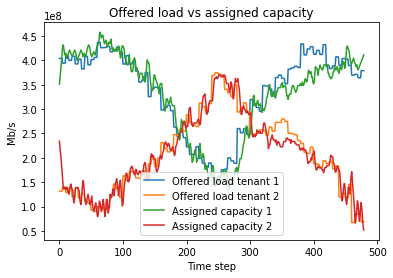

Finished Evaluation...


In [ ]:
#Obtain results

file_name='Evaluation_output_file_v2'

evaluation(k_tenants,n_BS,bs_controller_eval, env_tenants_tf_eval,eval_polices,file_name)